In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from tqdm import tqdm
import numpy as np
import tensorflow as tf
from PIL import Image
import os
import pickle
import json
import cv2
import re

In [2]:
tf.test.is_gpu_available()

True

In [3]:
# make image dataloader using flow_from_dataframe
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# load data to extract labels
data_dir = 'mmhs150k/'
model_dir = 'models/'
tweet_dict = json.load(open(data_dir + 'MMHS150K_GT.json', 'r'))

In [4]:
# custom data generator to handle cropping
# https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
from random import randint # for random cropping

class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, splits_path, tweet_dict, batch_size=32, dim=(299, 299), n_channels=3, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.n_channels = n_channels
        self.shuffle = shuffle
        
        # build labels list and id list
        self.id_list = open(splits_path, 'r').read().splitlines()
        self.labels = dict()
        for id in self.id_list:
            binary_labels = [1 if n > 0 else 0 for n in tweet_dict[id]['labels']]
            label = 1 if sum(binary_labels)/len(tweet_dict[id]['labels']) > 0.5 else 0
            self.labels[id] = label
            
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.id_list) / self.batch_size)) + 1 # last batch is partial

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:index*self.batch_size + self.batch_size]
        
        
        # Find list of IDs
        id_list_temp = [self.id_list[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(id_list_temp)
        
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.id_list))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, id_list_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((len(id_list_temp), *self.dim, self.n_channels))
        y = np.empty(len(id_list_temp), dtype=int)

        # Generate data
        for i, ID in enumerate(id_list_temp):
            # Store sample
            X[i,] = self.process_img(data_dir + 'img_resized/' + ID + '.jpg')

            # Store class
            y[i] = self.labels[ID]

        return X, y
    
    def process_img(self, path): # method for getting image
        img = Image.open(path)
        img.load()
        data = np.asarray(img, dtype='uint8')
        im = self.augment(data)
        
        if im.shape==(self.dim[0], self.dim[1]): im = np.stack((im,)*3, axis=-1) # handle grayscale
        
        return im
    
    def get_labels(self): # get list of labels for calculating AUROC
        return [self.labels[ID] for ID in self.id_list]
    
    def augment(self, im): # random crop and random mirror
        
        # random crop
        x_max, y_max = im.shape[0], im.shape[1]
        x_start, y_start = randint(0, x_max - self.dim[0]), randint(0, y_max - self.dim[1])
        im = im[x_start:x_start + self.dim[0], y_start:y_start + self.dim[1]]
        
        # random mirror
        if randint(0,1): im = np.flip(im, axis=1)
        
        return im

In [5]:
# create data generators
train_gen = DataGenerator(splits_path=data_dir + 'splits/train_ids.txt',
                          tweet_dict=tweet_dict,
                          batch_size=32,
                          dim=(299, 299),
                          n_channels=3,
                          shuffle=True)

val_gen = DataGenerator(splits_path=data_dir + 'splits/val_ids.txt',
                          tweet_dict=tweet_dict,
                          batch_size=32,
                          dim=(299, 299),
                          n_channels=3,
                          shuffle=True)

test_gen = DataGenerator(splits_path=data_dir + 'splits/test_ids.txt',
                          tweet_dict=tweet_dict,
                          batch_size=32,
                          dim=(299, 299),
                          n_channels=3,
                          shuffle=False)

In [6]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten

conv_base = tf.keras.applications.inception_v3.InceptionV3(include_top=False, 
                                                        weights='imagenet', 
                                                        input_shape=(299, 299, 3))
# for layer in conv_base.layers[:-1]: layer.trainable = False # freeze pretrained layers

model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(2048, activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
print(model.summary())

optimizer = Adam(lr = 0.0001)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 8, 8, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
dense (Dense)                (None, 2048)              268437504 
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 513       
Total params: 292,863,777
Trainable params: 292,829,345
Non-trainable params: 34,432
_____________________________________

In [7]:
# train model
history = model.fit_generator(train_gen,
                    validation_data=val_gen,
                    shuffle=True,
                    epochs=1,
                    class_weight={0: 1, 1: 1/0.28})


4214/4214 [==============================] - 6912s 2s/step - loss: 1.0933 - accuracy: 0.5450 - val_loss: 0.6929 - val_accuracy: 0.5362


In [8]:
# test
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score
import math

y_test = test_gen.get_labels()

# get AUROC
preds = model.predict_generator(test_gen)
print('Test AUROC:', roc_auc_score(y_test, preds))

# get loss and acc
preds_bin = np.array(preds)
preds_bin[preds>0.5] = 1
preds_bin[preds<=0.5] = 0
print('Test Accuracy:', accuracy_score(y_test, preds_bin))

# get F1
print('Test F1:', f1_score(y_test, preds_bin, zero_division=1))
print('Test Precision:', precision_score(y_test, preds_bin, zero_division=1))
print('Test Recall:', recall_score(y_test, preds_bin, zero_division=1))

Test AUROC: 0.5427744000000001
Test Accuracy: 0.5287
Test F1: 0.5440650091902874
Test Precision: 0.526887764661795
Test Recall: 0.5624


In [9]:
model.save(model_dir + 'cnn_weighted.h5')

In [10]:
# get loss and acc with lower threshold
preds_bin = np.array(preds)
preds_bin[preds>0.2] = 1
preds_bin[preds<=0.2] = 0
print('Test Accuracy:', accuracy_score(y_test, preds_bin))

# get F1
print('Test F1:', f1_score(y_test, preds_bin, zero_division=1))
print('Test Precision:', precision_score(y_test, preds_bin, zero_division=1))
print('Test Recall:', recall_score(y_test, preds_bin, zero_division=1))

Test Accuracy: 0.5
Test F1: 0.6666666666666666
Test Precision: 0.5
Test Recall: 1.0


In [11]:
# from tensorflow.keras.models import load_model

# model = load_model(model_dir + 'cnn_weighted.h5')

In [12]:
preds = model.predict_generator(test_gen)
y_test = np.array(test_gen.get_labels())

pos_preds = preds[y_test == 1]
neg_preds = preds[y_test == 0]

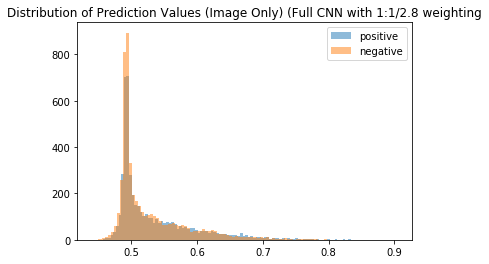

In [14]:
plt.title('Distribution of Prediction Values (Image Only) (Full CNN with 1:1/2.8 weighting')
plt.hist(pos_preds, bins=100, alpha=0.5, label='positive')
plt.hist(neg_preds, bins=100, alpha=0.5, label= 'negative')
plt.legend()